Simple Vanilla Neural Net 

PROJECT ROADMAP TO-DOs

( ) -- Flush out deep NN model, try adding 3-5 *layers*, and experiment with different sizes of those layers. Take it to the extremes, and try adding ~10+ layers to see how that changes the model.

( ) -- graph out accuracies of shallow AND deep models 

( ) -- explore the ideas of precision / recall, F1 score (read up about this). Write functions to calculate precision() and recall() for your models. Run these functions on ShallowNN, Logistic model, and DeepNN. Write function to compute F1 score -- compute_f1_score(), and run the same tests.

( ) -- Tune and *graph* different hyper-parameter experiments (lr, epoch, etc). 

( ) -- Try training on another data set (this can be another image set OR non-image data) 

In [125]:
#Image classifer with logistic regression
#images shape(width,height,3(rgb))

###to knit to html ipython nbconvert --to html [NEWFILENAME].html
import numpy as np
import scipy 
import os
import matplotlib.pyplot as plot
import math
from scipy import ndimage
from skimage import io
#from basicFunctions import crossEntropyLoss 
 

In [10]:
# Global Constants
side_length = 100
image_path = "./Logistic_Regression_Data/"
test_ratio = .3
epoch = 7000
learning_rate = .2
max_num_images = 300

In [11]:
def getImageArrays(path, side_length): #returns list of images arrays for a specified path
    image_names = os.listdir(path)
    image_names = image_names[:max_num_images]
    examples = []
    for image_name in image_names:
        if image_name.split(".")[-1] != "DS_Store":
            try:
                cur_image_path = path + image_name
                cur_image = np.array(ndimage.imread(cur_image_path,flatten=False))
                cur_array_resized = scipy.misc.imresize(cur_image,size=(side_length,side_length))
                cur_array_flattened = cur_array_resized.reshape((side_length*side_length*3)).T

                examples += [cur_array_flattened] 
            except ValueError:
                print("Error in creating examples",image_name)
                
    return examples

In [12]:
#create examples & labels
cow_images_path = image_path + "cows/"
notCow_image_path = image_path + "notcows/"

examples_cow = getImageArrays(cow_images_path, side_length)
labels_cow = np.ones(len(examples_cow))
examples_notCow = getImageArrays(notCow_image_path, side_length)
labels_notCow = np.zeros(len(examples_notCow))

examples_cow = np.array(examples_cow)
examples_notCow = np.array(examples_notCow)
#assert(examples_cow.shape[1:] == (side_length,side_length,3)), "examples_cow are invalid shape"
examples = np.concatenate((examples_cow,examples_notCow))
labels = np.concatenate((labels_cow,labels_notCow))
print("Number of Examples:",len(examples))
print("Number of Labels:",len(labels))


Error in creating examples notcow126.jpg
Number of Examples: 597
Number of Labels: 597


In [13]:
shuffled_indexing = np.random.permutation(labels.shape[0])
examples = examples[shuffled_indexing]
labels = labels[shuffled_indexing]

In [14]:
#seperate train and test examples
number_examples_test = int(len(examples)*test_ratio)
number_labels_test = int(len(labels)*test_ratio)

examples_test = examples[:number_examples_test]
examples_train = examples[number_examples_test:]
labels_test = labels[:number_labels_test]
labels_train = labels[number_labels_test:]
print("Number of training examples: ", examples_train.T.shape)
print("Number of test examples: ", examples_test.T.shape)
print(labels_train.shape)

Number of training examples:  (30000, 418)
Number of test examples:  (30000, 179)
(418,)


In [15]:
#reshape labels for future matrix operations
labels_train = np.reshape(labels_train,(1,len(labels_train)))
labels_test = np.reshape(labels_test,(1,len(labels_test)))

In [16]:
#flatten examples
# flattened_train_examples = examples_train.reshape(examples_train.shape[0], -1).T
# flattened_test_examples = examples_test.reshape(examples_test.shape[0], -1).T  
# print("flattened examples",flattened_test_examples.shape,flattened_train_examples.shape)
flattened_train_examples = examples_train.T
flattened_test_examples = examples_test.T

In [17]:
# Standardize color values of the image (decrease computational cost durring cross entropy)
standardized_train_examples = flattened_train_examples/255 #225 is the maximum rgb value/ This is done to decrease varaince in inputs thus more efficint
standardized_test_examples = flattened_test_examples/255
print("standardized",standardized_test_examples.shape,standardized_train_examples.shape)

standardized (30000, 179) (30000, 418)


In [18]:
def crossEntropyLoss(a,Y):
    num_of_examples = Y.shape[1] #len(Y) doesn't work, need 2nd dimesnion
    a = a.T
    loss = - (1.0 / num_of_examples) * (np.dot((1.0 - Y), np.log(1.0 - a)) + np.dot(Y, np.log(a)))
    return loss

In [19]:
def sigmoid(x):
    output = 1.0/(1.0+np.exp(-x))
    cached_value = x
    cached_value = {"out_a":x}
    return output, cached_value

In [20]:
def relu(x,leaky=0):
    output = np.maximum(leaky,x)
#     cached_value = x
    cached_value = {"out_a":x}
    return output, cached_value
    

In [21]:
def initialize_params_shallow(input_layer, hidden_layer, output_layer):
    w1 = np.random.randn(hidden_layer,input_layer)
    w2 = np.random.randn(output_layer,hidden_layer)
    #np.random.randn gives numbers larger than 1 so: (vanishing/exploading gradients)
    w1,w2 = w1 * .01, w2 * .01
    
    #is it by one because of broadcasting 
    b1 = np.zeros((hidden_layer,1))
    b2 = np.zeros((output_layer,1))
    
    assert(w1.shape == (hidden_layer, input_layer))
    assert(w2.shape == (output_layer, hidden_layer))
    assert(b1.shape == (hidden_layer,1))
    assert(b2.shape == (output_layer,1))
    
    return {"w1":w1,"w2":w2,"b1":b1,"b2":b2}

In [22]:
def initialize_params_deep(input_layer, hidden_layers, output_layer):
#     np.random.seed(3) #non random random numbers (will get the same random numbers each time) used for testing
    layers = {} #dictionary of weights and biasis
    previous_layer = input_layer #sets the begining shape as shape of input layer
    for i in range(len(hidden_layers)):
        cur_layer = hidden_layers[i]
        weights = np.random.randn(cur_layer,previous_layer)
        weights *= .01 #because np.random.rand returns numbers too large, more efficeint durring gradient descensed 
        bias = np.zeros((cur_layer,1))
        cur_weights_key = "w" + str(i + 1) # i + 1 because humans like things indexed at 0
        cur_bias_key = "b" + str(i + 1)
        layers[cur_weights_key] = weights
        layers[cur_bias_key] = bias 
        
        assert(layers["w" + str(i + 1)].shape == (cur_layer, previous_layer))
        assert(layers["b" + str(i + 1)].shape == (cur_layer,1))
        
        previous_layer = cur_layer

    layers["w" + str(len(hidden_layers) + 1)] = np.random.randn(output_layer,previous_layer) * .01
    layers["b" + str(len(hidden_layers) + 1)] = np.zeros((output_layer,1))

    return layers

In [23]:
def linear_forward_prop(a,w,b): #a because a is from the past layer
#     print("Before Transpose -- A:",a.shape,"W:",w.shape,"B:",b.shape)
#     print("After Transpose -- A:",a.shape,"W:",w.shape,"B:",b.shape)
    z = np.dot(w,a) + b
#     print("z:",z.shape)
#     print("z",z.shape,"a",a.shape[0],"w",w.shape[1],"b",b.shape)
#     assert(z.shape == (a.shape[0], w.shape[1] ))
    #     assert(z.shape == np.dot(a,w).shape)
    cached_inputs = {"in_a":a,"w":w,"b":b,"z":z} #(a,w,b)
    return z,cached_inputs
    

In [24]:
def singleFowardPropagation(X,w,b,activationType,leaky=0): #TODO change x to a
#     cached_inputs = {"w":None,"x":None,"b":None,"z":None}
    z,cached_values = linear_forward_prop(X,w,b)
    if activationType == "sigmoid":
        a, activation_cache = sigmoid(z)
    if activationType == "relu":
        a, activation_cache = relu(z,leaky=leaky)
    cached_values.update(activation_cache)
    return a, cached_values

In [108]:
def fowardPropagate(X,params):
    num_layers = len(params) // 2 #// rounds down
    #assert len params is even
    a = X
    cached_values = []
    for i in range(1,num_layers):
        w = params["w" + str(i)]
        b = params["b" + str(i)]
        past_a = a
        a, cur_cached = singleFowardPropagation(past_a,w,b,"relu")
        cached_values += [cur_cached] #TODO: get foramt of cached values 
        
    w = params["w" + str(num_layers)]
    b = params["b" + str(num_layers)]
    a, cur_cached = singleFowardPropagation(a,w,b,"sigmoid")
    cached_values += [cur_cached] 
    #write assert statemt here
    return a, cached_values

In [94]:
def linearBackprop(cached_values, dZ):
    a = cached_values["in_a"]
    w = cached_values["w"]
    b = cached_values["b"]
    number_examples = a.shape[1]
    dW = (1.0/number_examples) * np.dot(dZ,a.T)
    dB = (1.0/number_examples) * np.sum(dZ, axis = 1, keepdims= True)
    dA = np.dot(w.T, dZ)
    return {"dW":dW,"dB":dB,"dA":dA}
    
    

In [27]:
def relu_backward(dA, z):
    dZ = np.array(dA, copy=True) #convert dA to np array
    dZ[z <= 0] = 0
    return dZ
    

In [28]:
def sigmoid_backward(dA, z):
    s = 1/(1 + np.exp(-z))
    dz = dA * s * (1-s) 
    
    return dz

In [29]:
def backwards_activation(dA, cached_values, activation_type):
    if activation_type == "sigmoid":
        dZ = sigmoid_backward(dA, cached_values["z"])
    if activation_type == "relu":
        dZ = relu_backward(dA, cached_values["z"])
    gradients = linearBackprop(cached_values, dZ)
    return gradients
    
    #todo write optimizer function
        
        
    

In [30]:
def backprop(a, cached_values, y):
    gradients = {}
    num_layers = len(cached_values)
    y = y.reshape(a.shape)

    dFinalA = -(np.divide(y,a) - np.divide(1-y, 1-a)) #dervivative of output of foward pass 
    backwards_activation_output_0 = backwards_activation(dFinalA, cached_values[-1],"sigmoid")
    
    gradients["dW" + str(num_layers)] = backwards_activation_output_0["dW"]
    gradients["dB" + str(num_layers)] = backwards_activation_output_0["dB"]
    gradients["dA" + str(num_layers - 1)] = backwards_activation_output_0["dA"]
    
    for i in reversed(range(num_layers - 1)):
        past_layer = cached_values[i]
        cur_dLayer = backwards_activation(gradients["dA" + str(i + 1)], past_layer, "relu")
        gradients["dW" + str(i + 1)] = cur_dLayer["dW"]
        gradients["dB" + str(i + 1)] = cur_dLayer["dB"]
        gradients["dA" + str(i)] = cur_dLayer["dA"]
    return gradients

In [31]:
def optimize(grads,params, learning_rate):
    num_layers = len(params)//2
    for i in range(num_layers): #subtraction
#         print("lr",learning_rate)
#         print("w-before (", str(i+1), "): ", params["w" + str(i +1)])
#         print("b-before (", str(i+1), "): ", params["b" + str(i +1)])
#         print("------------")
#         print("dW",grads["dW" + str(i + 1)])
#         print("dB",grads["dB" + str(i + 1)])
        params["w" + str(i +1)] = params["w" + str(i + 1)] - (grads["dW" + str(i + 1)] * learning_rate)
        params["b" + str(i + 1)] = params["b" + str(i + 1)] - (grads["dB" + str(i + 1)] * learning_rate)
#         print("w-after (", str(i+1), "): ", params["w" + str(i +1)])
#         print("b-after (", str(i+1), "): ", params["b" + str(i +1)])
    return params

In [32]:
np.random.seed(3)
a = np.random.randn(1, 2)
a1 = np.random.randn(4, 2)
b1 = np.random.randn(3, 4)
w1 = np.random.randn(3, 1)
z1 = np.random.randn(3, 2)
cache1 = [{"in_a" : a1,"b" : b1,"w" : w1, "z" : z1}]
a2 = np.random.randn(3, 2)
b2 = np.random.randn(1, 1)
w2 = np.random.randn(1, 3)
z2 = np.random.randn(1, 2)
cache2 = [{"in_a" : a2,"b" : b2,"w" : w2, "z" : z2}]
megaCache = cache1 +  cache2
y = np.array([[1,0]])
# print("y",y)
# print(megaCache[0]["in_a"],"in_a1")
# print(megaCache[0]["b"],"b1")
# print(megaCache[0]["w"],"w1")
# print(megaCache[0]["z"],"z1")
# print(megaCache[1]["in_a"],"in_a2")
# print(megaCache[1]["b"],"b2")
# print(megaCache[1]["w"],"w2")
# print(megaCache[1]["z"],"z2")


grads = backprop(a, megaCache,y)
print("dA0", grads["dA0"].shape)
print("dW1", grads["dW1"].shape)
print("dB1", grads["dB1"].shape)
print("dW2", grads["dW2"].shape)
print("dB2", grads["dB2"].shape)
print("dA1", grads["dA1"].shape)
print(grads)

dA0 (1, 2)
dW1 (3, 4)
dB1 (3, 1)
dW2 (1, 3)
dB2 (1, 1)
dA1 (3, 2)
{'dW2': array([[-0.39202432, -0.13325855, -0.04601089]]), 'dB2': array([[ 0.15187861]]), 'dA1': array([[-0.14175655,  0.48317296],
       [ 0.01663708, -0.05670698],
       [ 0.20472941, -0.69781407]]), 'dW1': array([[-0.45019464, -0.08570497, -0.15147489, -0.11528942],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.65018572,  0.1237779 ,  0.21876495,  0.16650473]]), 'dB1': array([[ 0.24158648],
       [ 0.        ],
       [-0.34890704]]), 'dA0': array([[ 0.        ,  1.43247838]])}


In [33]:
# def optimizer(params,examples,learing_rate,epoch):
#     for i in range(epoch):
#         for X,y in examples:
#             a, cache = fowardPropagate(X,params)
#             grads = backprop(a,params,cache,Y)
#             for key,value in params:
#                 if key[1] != "A": 
#                     cur_grad = grads["d" + key]
#                     value = value - (learning_rate * grad)                    

In [34]:
input_layer = 12288 #change to side length*length*3 
hidden_layer = 7
output_layer = 1

In [35]:
def shallowNN(X,y,epoch,lr,input_layer,hidden_layer,output_layer):
    params = initialize_params_shallow(input_layer,hidden_layer,output_layer)
    costs = []
    grads = {}
    for i in range(epoch):
        w1 = params["w1"]
        w2 = params["w2"]
        b1 = params["b1"]
        b2 = params["b2"]
        a1, cached_values1 = singleFowardPropagation(X,w1,b1,"relu")
        a2, cached_values2 = singleFowardPropagation(a1,w2,b2,"sigmoid")
        # backwards [end] (1,710) --> (7,710) --> (exmample size,710) [start]
        cost = crossEntropyLoss(a2,y)
        dFinalA = -(np.divide(y,a2) - np.divide(1.0-y, 1.0-a2))
#         print("dfinal a", dFinalA.shape)
        backwards_activation_output_0 = backwards_activation(dFinalA, cached_values2,"sigmoid")
#         print("penultimate activation",np.shape(backwards_activation_output_0["dA"]))
        backwards_activation_output_1 = backwards_activation(backwards_activation_output_0["dA"], cached_values1,"relu")
#         print("last activation",np.shape(backwards_activation_output_1["dA"]))
        grads["dW1"] = backwards_activation_output_1["dW"]
        grads["dW2"] = backwards_activation_output_0["dW"]
        grads["dB1"] = backwards_activation_output_1["dB"]
        grads["dB2"] = backwards_activation_output_0["dB"]
        params = optimize(grads, params, learning_rate)
        
        costs += [cost]
        if i % 100 == 0:
            print("Costs @ " + str(i) + ":",cost)    
    return params, costs

In [2]:
def shallowNNTest(X,y,params):
    w1 = params["w1"]
    w2 = params["w2"]
    b1 = params["b1"]
    b2 = params["b2"]
    a1, cached_values1 = singleFowardPropagation(X,w1,b1,"relu")
    a2, cached_values2 = singleFowardPropagation(a1,w2,b2,"sigmoid")
    loss = 1 - np.mean(np.abs(a2-y))
    print("Test Accuracey:",loss * 100,"%")
    return loss 

In [37]:
X = standardized_train_examples
y = labels_train
input_layer = side_length * side_length * 3
hidden_layer = 7
output_layer = 1
learning_rate = .01
params,costs = shallowNN(X,y,2000,learning_rate,input_layer,hidden_layer,output_layer)

Costs @ 0: [[ 0.694481]]
Costs @ 100: [[ 0.67193261]]
Costs @ 200: [[ 0.55183531]]
Costs @ 300: [[ 0.5013363]]
Costs @ 400: [[ 0.41537091]]
Costs @ 500: [[ 0.47459094]]
Costs @ 600: [[ 0.35189036]]
Costs @ 700: [[ 0.31209632]]
Costs @ 800: [[ 0.33203535]]
Costs @ 900: [[ 0.59690081]]
Costs @ 1000: [[ 0.73786394]]
Costs @ 1100: [[ 0.1939685]]
Costs @ 1200: [[ 0.25965263]]
Costs @ 1300: [[ 0.16715905]]
Costs @ 1400: [[ 0.1335017]]
Costs @ 1500: [[ 0.11675571]]
Costs @ 1600: [[ 0.12398771]]
Costs @ 1700: [[ 0.09211641]]
Costs @ 1800: [[ 0.08254843]]
Costs @ 1900: [[ 0.06815313]]


In [3]:
X = standardized_test_examples
y = labels_test
loss = shallowNNTest(X,y,params)

NameError: name 'standardized_test_examples' is not defined

In [39]:
def deepNN(X,y,epoch,lr,input_layer,hidden_layers,output_layer):
    params = initialize_params_deep(input_layer,hidden_layers,output_layer)
    costs = []
    for i in range(epoch):
        a, cache = fowardPropagate(X,params)
        cost = crossEntropyLoss(a,y)
        grads = backprop(a, cache, y)
        params = optimize(grads, params, lr)
        if i % 200 == 0:
            print("Cost @",i,cost)
        costs += cost
    return params,costs
            
        
        
        

In [156]:
def deepNNEval(X,y,params):
    a, _ = fowardPropagate(X,params)
    loss = np.mean(np.abs(a-y))
    loss2 = 1 - np.mean(np.abs(np.round(a)-y)) 
    print(loss,loss2)
    return loss

In [152]:
X = standardized_train_examples
y = labels_train
input_layer = side_length * side_length * 3
hidden_layers = [7, 5]
output_layer = 1
learning_rate = .01
params, costs = deepNN(X,y,5000,learning_rate,input_layer,hidden_layers,output_layer)

Cost @ 0 [[ 0.69314655]]
Cost @ 200 [[ 0.69268057]]
Cost @ 400 [[ 0.69250662]]
Cost @ 600 [[ 0.69243805]]
Cost @ 800 [[ 0.69240435]]
Cost @ 1000 [[ 0.69237692]]
Cost @ 1200 [[ 0.69233579]]
Cost @ 1400 [[ 0.69224376]]
Cost @ 1600 [[ 0.69196371]]
Cost @ 1800 [[ 0.6906953]]
Cost @ 2000 [[ 0.68256019]]
Cost @ 2200 [[ 0.63583993]]
Cost @ 2400 [[ 0.55066422]]
Cost @ 2600 [[ 0.4492255]]
Cost @ 2800 [[ 0.40381603]]
Cost @ 3000 [[ 0.3450689]]
Cost @ 3200 [[ 0.41257334]]
Cost @ 3400 [[ 0.31932966]]
Cost @ 3600 [[ 0.22148779]]
Cost @ 3800 [[ 0.24571632]]
Cost @ 4000 [[ 0.15491017]]
Cost @ 4200 [[ 0.15241917]]
Cost @ 4400 [[ 0.47575565]]
Cost @ 4600 [[ 0.39589084]]
Cost @ 4800 [[ 0.27598721]]


In [157]:
X = standardized_test_examples
y = labels_test
loss = deepNNEval(X,y,params)

0.343098914202 0.698324022346


In [120]:
def getImage(image_path,side_length,show=True):
    if (image_path.split(":")[0] == "http") or (image_path.split(":")[0] == "https"):
        try:
            image = io.imread(image_path)
        except:
            print("Sorry, but this url forbids requests from machines :(")
            assert(5 == 4)
    else:
        image = np.array(ndimage.imread(image_path, flatten=False))
    if show == True:
        io.imshow(image)
        io.show()
    array_resized = scipy.misc.imresize(image, size=(side_length,side_length))
    array_flattened = array_resized.reshape((side_length*side_length*3, 1))
    array_standardized = array_flattened/225
    return array_standardized 

In [141]:
def classify(image_path, params):
    side_length = int((params["w1"].shape[1]/3) ** .5)
    image_array = getImage(image_path, side_length)
    label,_ = fowardPropagate(image_array,params)
    if round(label[0][0]) == 1:
        print("Mœ",label[0][0])
    if round(label[0][0]) == 0:
        print("This is not a cow",label[0][0])
    

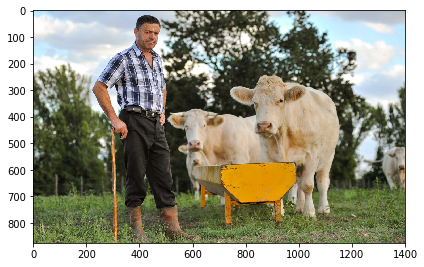

This is not a cow 0.102075691985


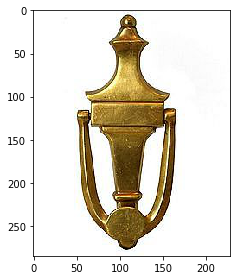

This is not a cow 1.05809995892e-07


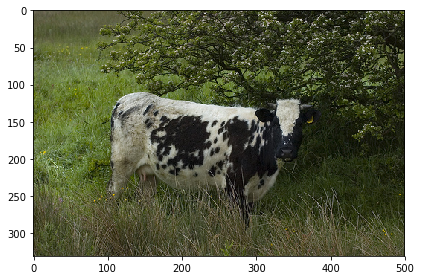

Mœ 0.935133716832


In [142]:
url = "https://images.unsplash.com/photo-1469365897239-504fabc9b11b?ixlib=rb-0.3.5&ixid=eyJhcHBfaWQiOjEyMDd9&s=1a1886339e4b1fd59eb0ae330b150899&auto=format&fit=crop&w=1400&q=80"
classify(url,params)
classify("./Logistic_Regression_Data/notcows/notcow7.jpg",params)
classify("./Logistic_Regression_Data/cows/cow10.jpg",params)